In [1]:
import numpy as np
import os
from astropy.io import fits
from astropy import units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter
from IPython.display import Image
# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
from IPython.display import Image
import glob

from PIL import Image
import numpy as np
import pylab as pl
pl.style.use('dark_background')

from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LinearLSQFitter

from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter


# Jupiter

In [2]:
jupiter_10s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\jupiter_10s001.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

jupiter_array = np.array(jupiter_10s_image_data)
jupiter_array = jupiter_array - np.median(jupiter_10s_image_data)

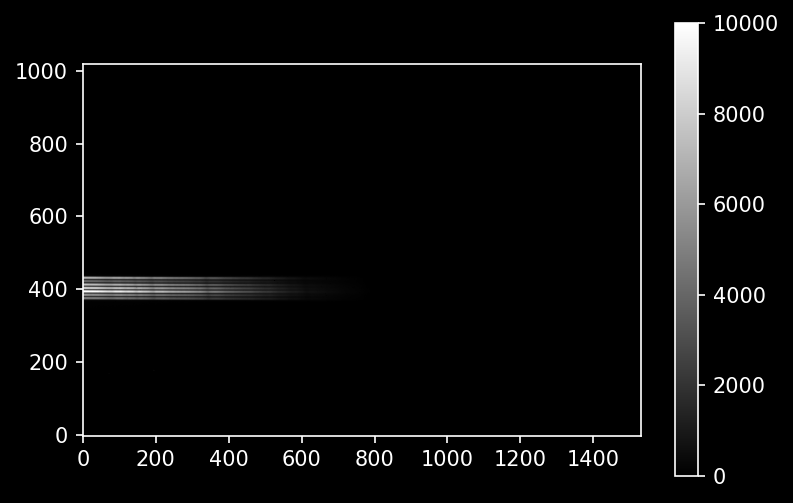

In [3]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(jupiter_10s_image_data, cmap='gray', vmax=0, vmin=10000)
pl.colorbar()

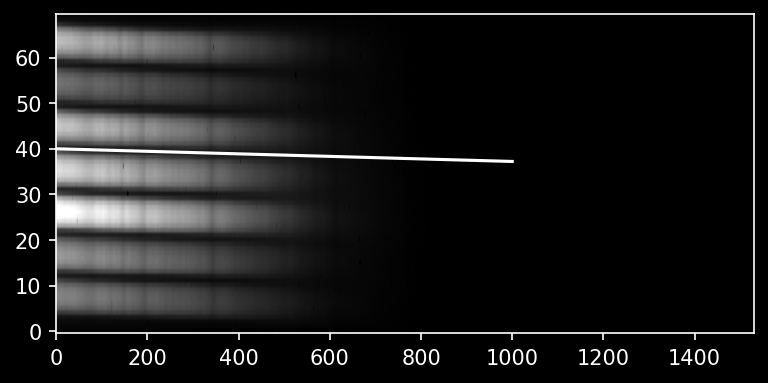

In [4]:
dy = -2.5
dx = 900
slope = dy/dx

ystart = 369
yend = 439

pl.imshow(jupiter_array[ystart:yend,:], cmap='gray', vmax=10000, vmin=0)
pl.plot([0,1000], 40 + np.array([0,1000]) * slope, color='w')
pl.gca().set_aspect(10)

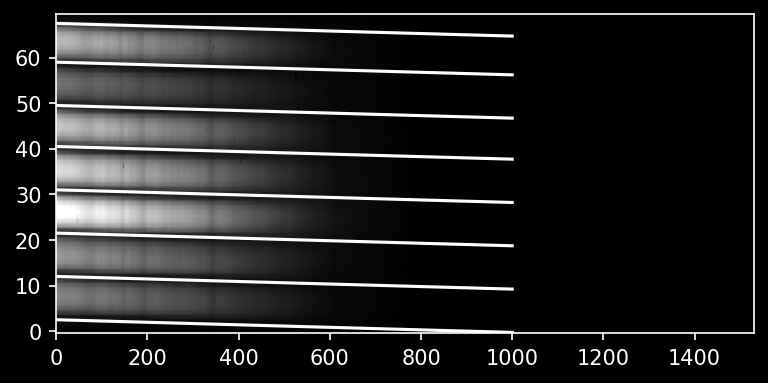

In [5]:
intertrace_cuts = np.array([2.5, 12, 21.5, 31, 40.5, 49.5, 59, 67.5])
pl.imshow(jupiter_array[ystart:yend,:], cmap='gray', vmax=10000, vmin=0)
pl.plot([0,1000], intertrace_cuts + np.array([0,1000])[:,None] * slope, color='w')
pl.gca().set_aspect(10)

In [6]:
npixels_to_cut = 4 # very conservative - we'll see why below
xvals = np.arange(jupiter_array.shape[1])
trace_center = ystart+(intertrace_cuts[2] + intertrace_cuts[3])/2 + xvals * slope
cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)]).T
cutout_trace.shape

(8, 1530)

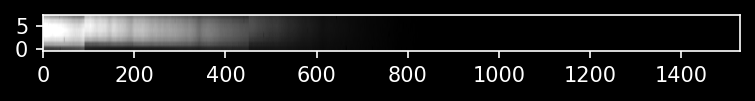

In [7]:
pl.imshow(cutout_trace, cmap='gray', vmax=10000, vmin=0)
pl.gca().set_aspect(10);

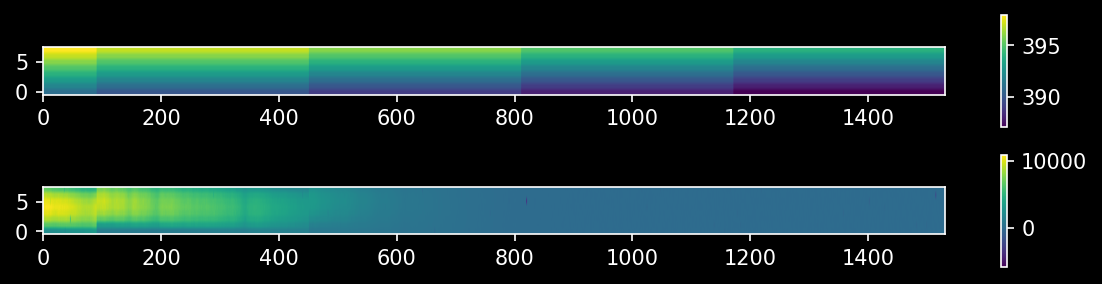

In [8]:
# to get the y-axis values corresponding to each part of our cutout trace, we do the same operation we did on the image
yaxis_full = np.arange(jupiter_array.shape[0])
yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                    for yval, ii in zip(trace_center, xvals)]).T

pl.figure(figsize=(8,2))
im = pl.subplot(2,1,1).imshow(yaxis)
pl.colorbar(mappable=im)
pl.gca().set_aspect(10);
im = pl.subplot(2,1,2).imshow(cutout_trace)
pl.colorbar(mappable=im)
pl.gca().set_aspect(10);
pl.tight_layout();

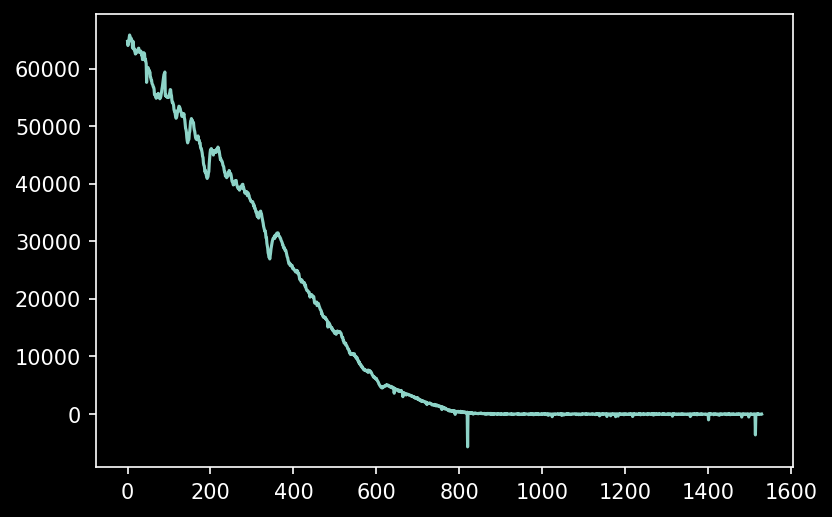

In [9]:
pl.plot(cutout_trace.sum(axis=0))

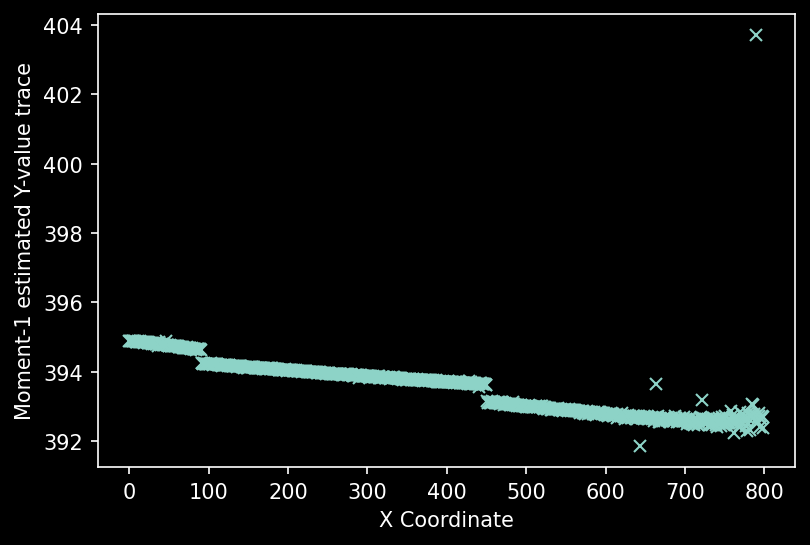

In [10]:
# moment 1 is the data-weighted average of the Y-axis coordinates
xend = 800
weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
_=pl.plot(xvals[:xend], weighted_yaxis_values, 'x')
_=pl.xlabel("X Coordinate")
_=pl.ylabel("Moment-1 estimated Y-value trace")

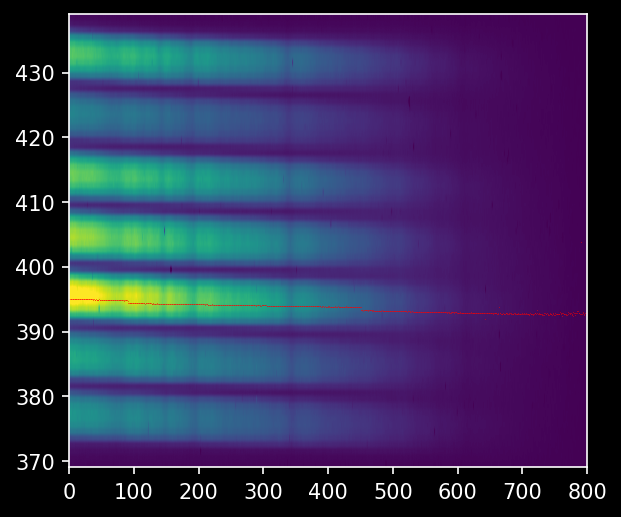

In [11]:
# we need to use the 'extent' keyword to have the axes correctly labeled
_=pl.imshow(jupiter_array[ystart:yend, :xend],
            extent=[0,xend,ystart,yend], vmax=10000, vmin=0)
_=pl.gca().set_aspect(10) # we stretch the image out by 10x in the y-direction
_=pl.plot(xvals[:xend], weighted_yaxis_values[:xend], 'r,', alpha=0.5)
_=pl.axis((0,xend,ystart,yend))

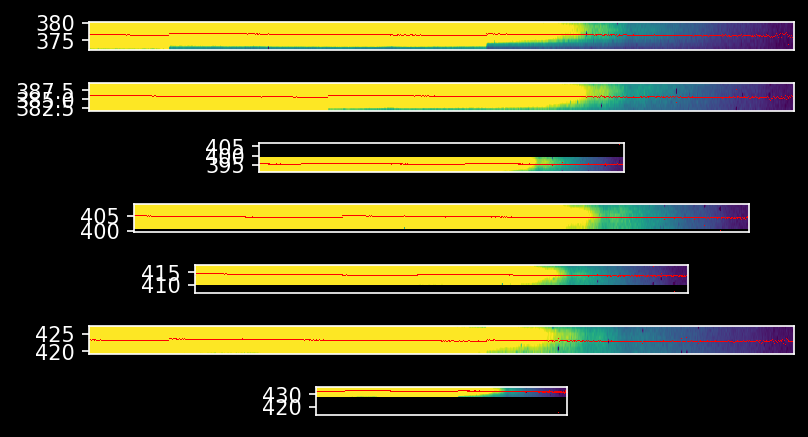

In [12]:
pl.figure(figsize=(8,3))
traces = {}
for trace_index in range(len(intertrace_cuts)-1):
    yoffset = ystart + (intertrace_cuts[trace_index] + intertrace_cuts[trace_index+1])/2
    trace_center = yoffset + slope * xvals

    cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                        for yval, ii in zip(trace_center, xvals)]).T
    yaxis = np.array([yaxis_full[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut]
                     for yval, ii in zip(trace_center, xvals)]).T
    weighted_yaxis_values = np.average(yaxis[:,:xend], axis=0,
                                   weights=cutout_trace[:,:xend])
    
    # it takes a little mental gymnastics to get to this, but: to show the trace properly on our cutout,
    # we need to calculate the local version
    local_weighted_yaxis_values = np.average(np.arange(npixels_to_cut*2)[:,None] * np.ones(xend)[None,:],
                                             axis=0, weights=cutout_trace[:,:xend])
    
    traces[trace_index] = weighted_yaxis_values
    ax = pl.subplot(7, 1, trace_index+1)
    ax.imshow(cutout_trace[:,:xend], extent=[0, xend, yoffset-npixels_to_cut, yoffset + npixels_to_cut],vmax=800, vmin=0 )
    ax.plot(xvals[:xend], yoffset - npixels_to_cut + local_weighted_yaxis_values[:xend], 'r,')
    ax.set_aspect(4)
    ax.set_xticks([])
pl.tight_layout()

(0.0, 800.0, 369.0, 439.0)

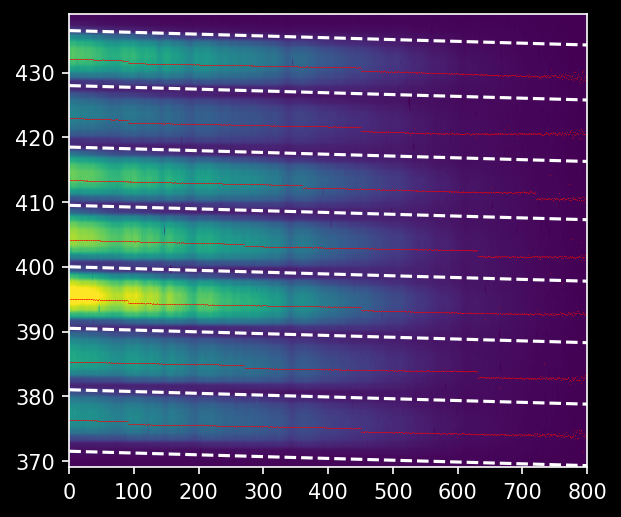

In [13]:
# then we can plot the "global" version here
pl.imshow(jupiter_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend], vmax=10000, vmin=0)
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for trace in traces.values():
    pl.plot(xvals[:xend], trace[:xend], 'r,', alpha=0.5)
pl.axis((0,xend,ystart,yend))

In [14]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

(0.0, 800.0, 369.0, 439.0)

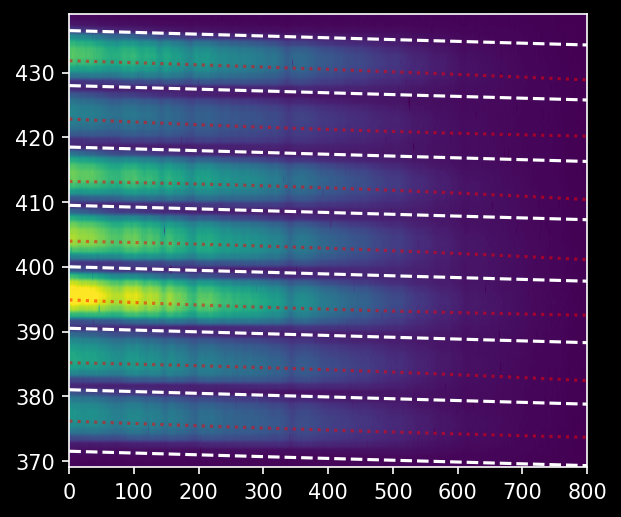

In [15]:
pl.imshow(jupiter_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=10000,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

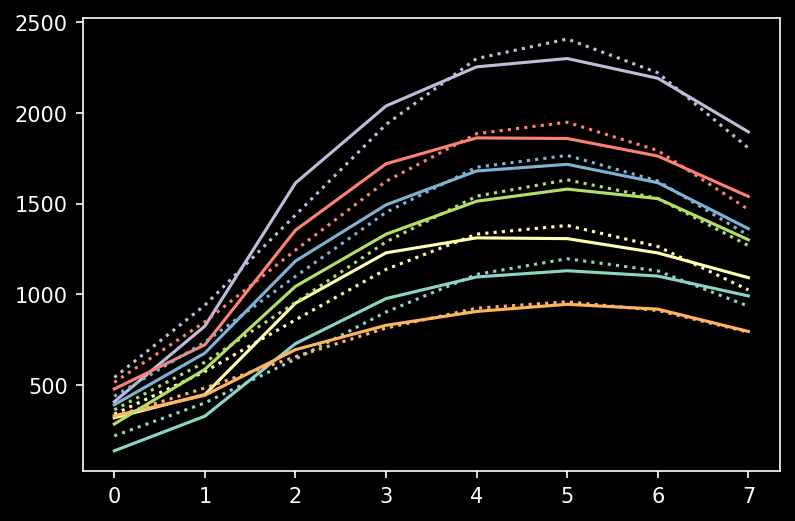

In [16]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)
npixels_to_cut_trace = 4

for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    line, = pl.plot(trace_profile, label=trace_index)
    pl.plot(trace_profile_xaxis, model_trace_profile, color=line.get_color(), linestyle=':')

In [17]:
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([jupiter_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            jupiter_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum

(0.0, 800.0)

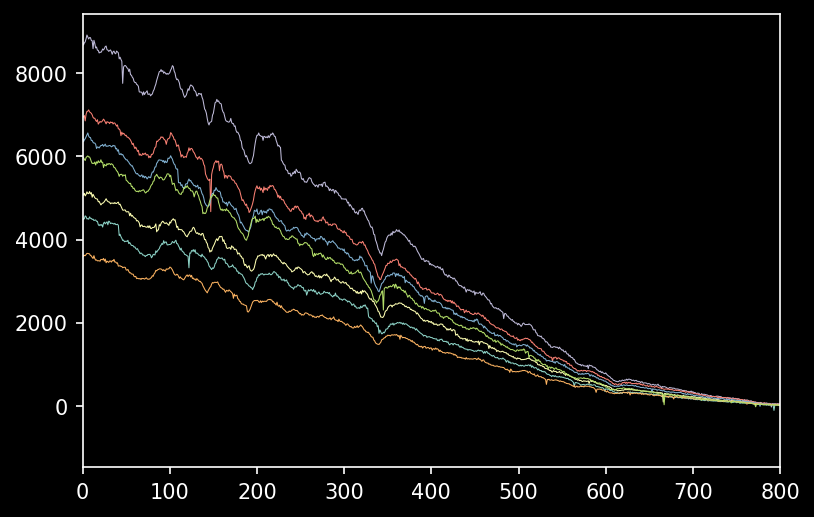

In [18]:
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
pl.xlim(0,800)

In [19]:
fitted_polymodels

{0: <Polynomial1D(2, c0=376.15424871, c1=-0.00379299, c2=0.00000082)>,
 1: <Polynomial1D(2, c0=385.17841428, c1=-0.00194809, c2=-0.00000189)>,
 2: <Polynomial1D(2, c0=394.89094474, c1=-0.00428583, c2=0.00000166)>,
 3: <Polynomial1D(2, c0=403.96841129, c1=-0.00191925, c2=-0.00000208)>,
 4: <Polynomial1D(2, c0=413.19331433, c1=-0.0014969, c2=-0.00000251)>,
 5: <Polynomial1D(2, c0=422.83141761, c1=-0.00475088, c2=0.00000182)>,
 6: <Polynomial1D(2, c0=431.84757099, c1=-0.00298514, c2=-0.0000009)>}

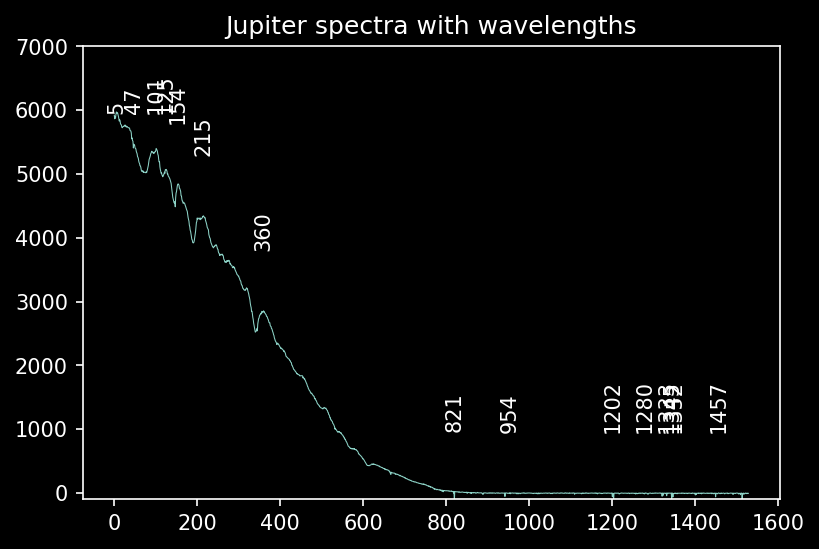

In [20]:
import scipy.signal

mean_jup = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_jup, linewidth = 0.5)
pl.title("Jupiter spectra with wavelengths")
pl.ylim(-100,7000)

peaks,_ = scipy.signal.find_peaks(mean_jup, prominence = 50)

for peak in peaks:
    pl.text(peak,
           min([mean_jup[peak] + 1000, 6000]), peak,
           rotation = 90, horizontalalignment = 'center',)

In [21]:
peaks

array([   5,   47,  101,  125,  154,  215,  360,  821,  954, 1202, 1280,
       1333, 1345, 1352, 1457], dtype=int64)

# Neon

In [22]:
ne_30s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\neon_30s002.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

ne_array = np.array(ne_30s_image_data)
ne_array = ne_array - np.median(ne_30s_image_data)

In [23]:
traces = {key: traces[key] for key in [1,2,3,4,5,6]}

(0.0, 800.0, 369.0, 439.0)

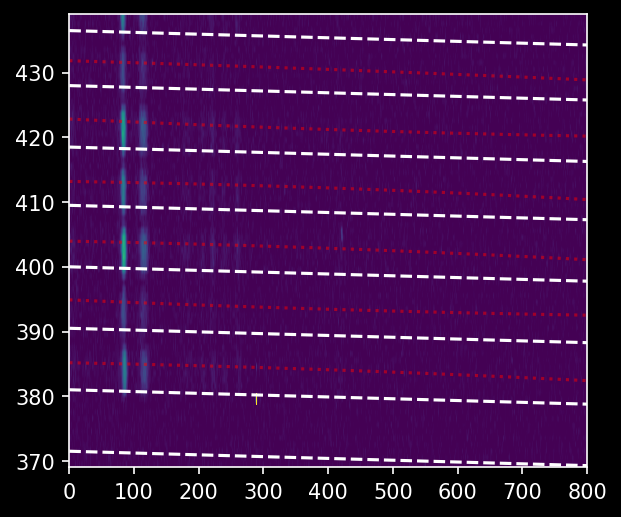

In [24]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(ne_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

(0.0, 800.0)

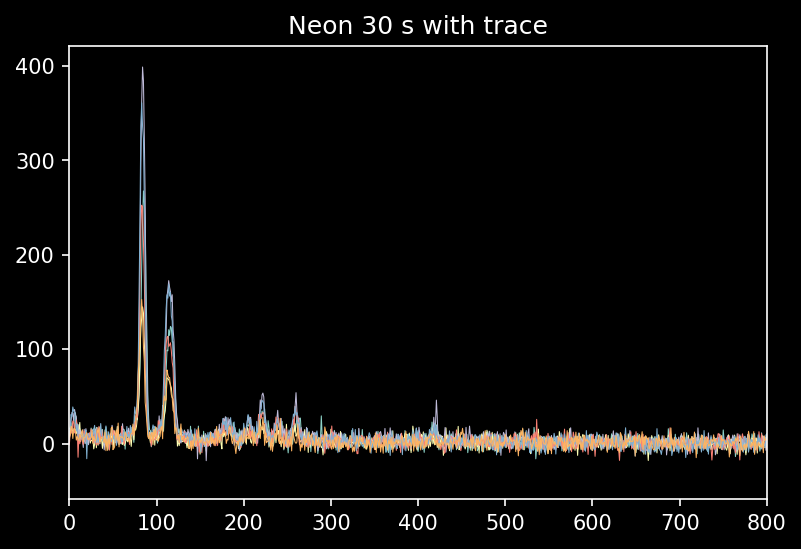

In [25]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([ne_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            ne_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Neon 30 s with trace")
pl.xlim(0,800)

In [26]:
fitted_polymodels

{1: <Polynomial1D(2, c0=385.17841428, c1=-0.00194809, c2=-0.00000189)>,
 2: <Polynomial1D(2, c0=394.89094474, c1=-0.00428583, c2=0.00000166)>,
 3: <Polynomial1D(2, c0=403.96841129, c1=-0.00191925, c2=-0.00000208)>,
 4: <Polynomial1D(2, c0=413.19331433, c1=-0.0014969, c2=-0.00000251)>,
 5: <Polynomial1D(2, c0=422.83141761, c1=-0.00475088, c2=0.00000182)>,
 6: <Polynomial1D(2, c0=431.84757099, c1=-0.00298514, c2=-0.0000009)>}

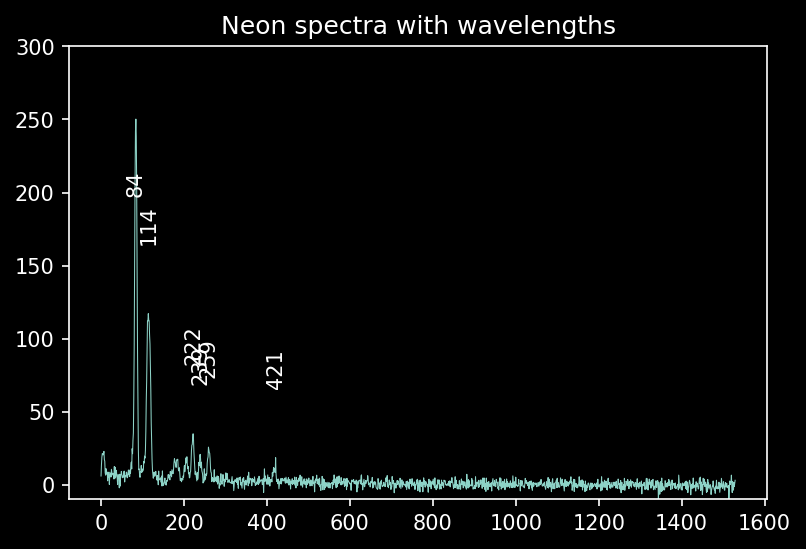

In [27]:
import scipy.signal

mean_ne = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_ne, linewidth = 0.5)
pl.title("Neon spectra with wavelengths")
pl.ylim(-10,300)

peaks,_ = scipy.signal.find_peaks(mean_ne, prominence = 17)

for peak in peaks:
    pl.text(peak,
           min([mean_ne[peak] + 50, 200]), peak,
           rotation = 90, horizontalalignment = 'center',)

In [28]:
peaks

array([ 84, 114, 222, 239, 259, 421], dtype=int64)

# Helium

In [29]:
## don't have darks for these so using 30 s - if hot pixles are sensitive then this might be an issue 
he_20s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\he_20s.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

he_array = np.array(he_20s_image_data)
he_array = he_array - np.median(he_20s_image_data)

(0.0, 800.0, 369.0, 439.0)

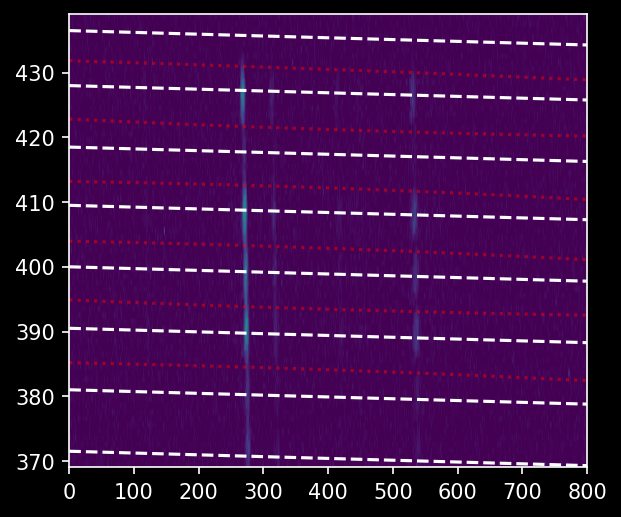

In [30]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(he_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

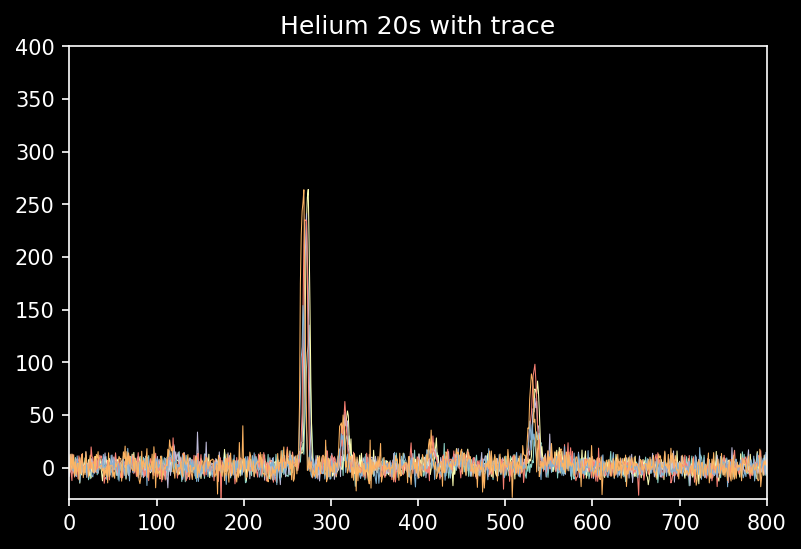

In [31]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([he_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            he_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Helium 20s with trace")
    pl.xlim(0,800)
    pl.ylim(-30,400)

Text(0.5, 1.0, 'Helium 20s with trace')

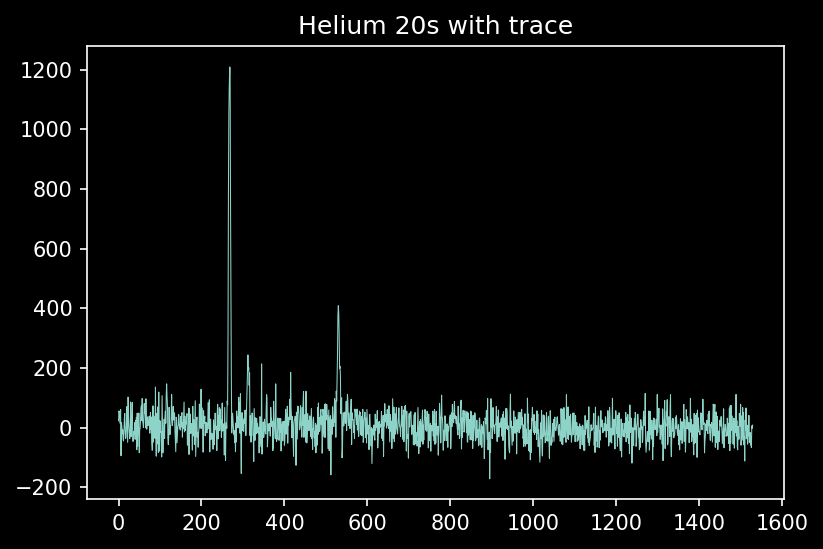

In [32]:
pl.plot(cutout_trace.sum(axis=0), linewidth=0.5)
pl.title("Helium 20s with trace")

In [33]:
fitted_polymodels

{1: <Polynomial1D(2, c0=385.17841428, c1=-0.00194809, c2=-0.00000189)>,
 2: <Polynomial1D(2, c0=394.89094474, c1=-0.00428583, c2=0.00000166)>,
 3: <Polynomial1D(2, c0=403.96841129, c1=-0.00191925, c2=-0.00000208)>,
 4: <Polynomial1D(2, c0=413.19331433, c1=-0.0014969, c2=-0.00000251)>,
 5: <Polynomial1D(2, c0=422.83141761, c1=-0.00475088, c2=0.00000182)>,
 6: <Polynomial1D(2, c0=431.84757099, c1=-0.00298514, c2=-0.0000009)>}

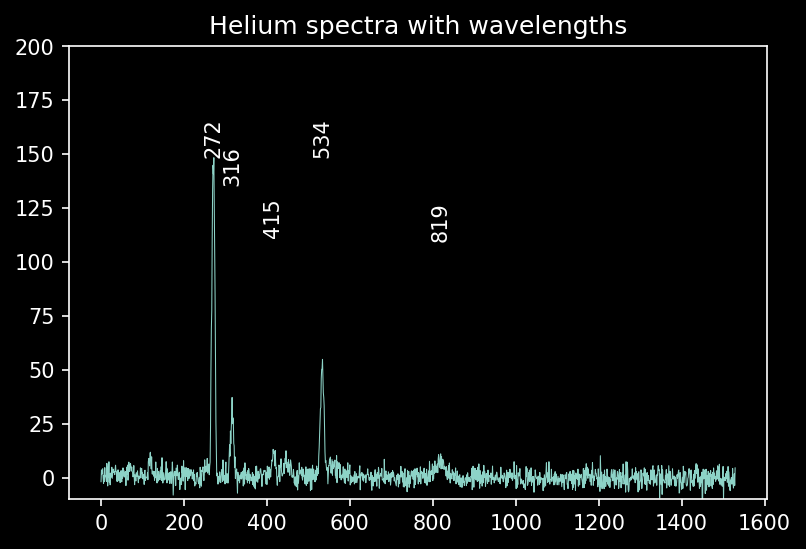

In [34]:
import scipy.signal

mean_he = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_he, linewidth = 0.5)
pl.title("Helium spectra with wavelengths")
pl.ylim(-10,200)

peaks,_ = scipy.signal.find_peaks(mean_he, prominence = 17)

for peak in peaks:
    pl.text(peak,
           min([mean_he[peak] + 100, 150]), peak,
           rotation = 90, horizontalalignment = 'center',)
    

In [35]:
peaks

array([272, 316, 415, 534, 819], dtype=int64)

In [36]:
xaxis = np.arange(he_20s_image_data.shape[1])

In [37]:
guessed_xvals = peaks
guessed_wavelengths = peaks#[303.78,320.30,505.5,522.21,584.22]
# https://physics.nist.gov/PhysRefData/Handbook/Tables/heliumtable2_a.htm
npixels = 15
improved_xval_guesses = [np.average(xaxis[g-npixels:g+npixels],
                                    weights=spectra[2][g-npixels:g+npixels] - np.median(spectra[2]))
                         for g in guessed_xvals]
improved_xval_guesses

[273.0266247785954,
 319.8742839925894,
 416.58896591491316,
 535.386496252356,
 819.9953733054045]

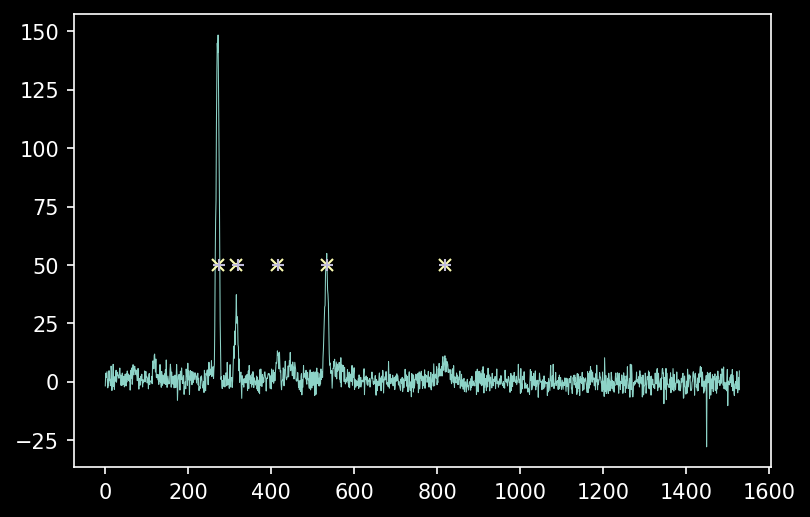

In [38]:
pl.plot(mean_he, linewidth = 0.5)
pl.plot(guessed_xvals, [50]*5, 'x')
pl.plot(improved_xval_guesses, [50]*5, '+');

In [39]:
wlmodel = Linear1D()
linfit_wlmodel = linfitter(model=wlmodel, x=improved_xval_guesses, y=guessed_wavelengths)
wavelengths = linfit_wlmodel(xaxis) * u.nm
linfit_wlmodel

<Linear1D(slope=1.00238884, intercept=-2.90420708)>

Text(0.5, 0, 'x (pixels)')

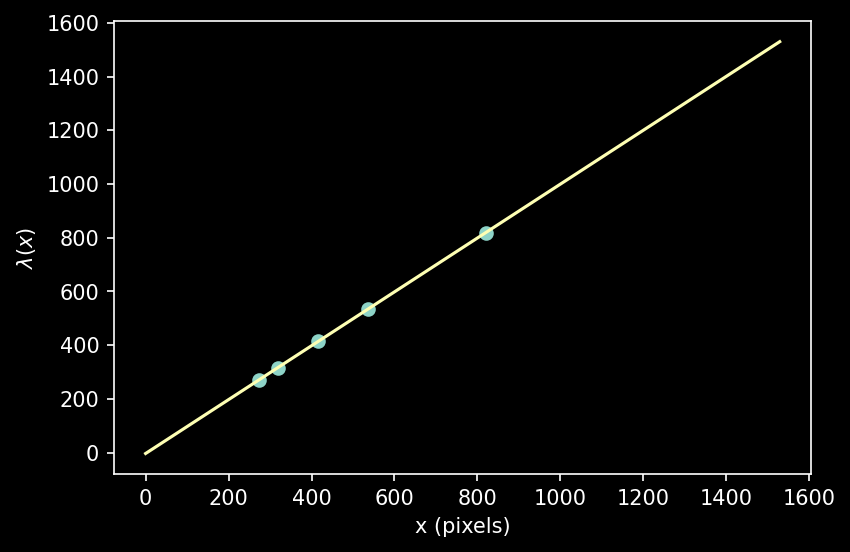

In [40]:
pl.plot(improved_xval_guesses, guessed_wavelengths, 'o')
pl.plot(xaxis, wavelengths, '-')
pl.ylabel("$\lambda(x)$")
pl.xlabel("x (pixels)")

In [41]:
# we adopt the minimum/maximum wavelength from our linear fit
minwave = wavelengths.min()
maxwave = wavelengths.max()
# then we search for atomic lines
# We are only interested in neutral lines, assuming the lamps are not hot enough to ionize the atoms
helium_lines = Nist.query(minwav=minwave,
                           maxwav=maxwave,
                           linename='He I')

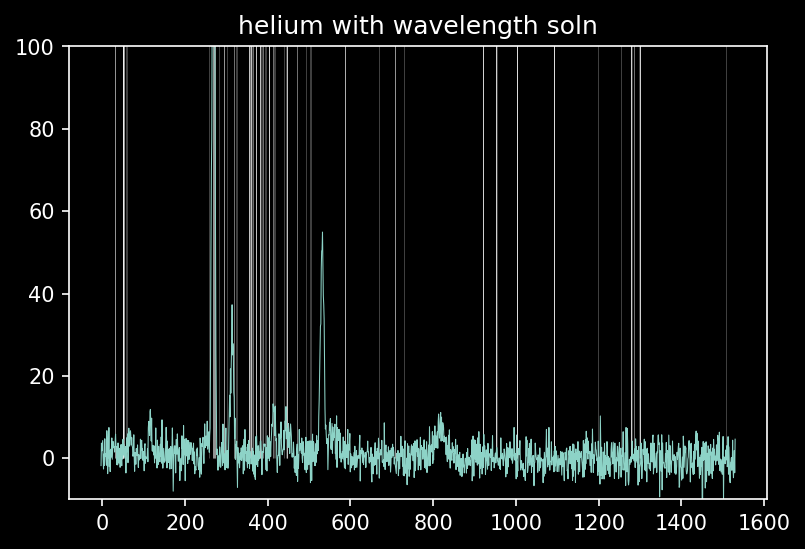

In [42]:
pl.plot(wavelengths, mean_he, linewidth = 0.5)
pl.ylim(-10,100)
pl.title("helium with wavelength soln")
pl.vlines(helium_lines['Observed'], 0, 250, 'w', alpha=0.25, linewidth = 0.5);

# Europa 30s

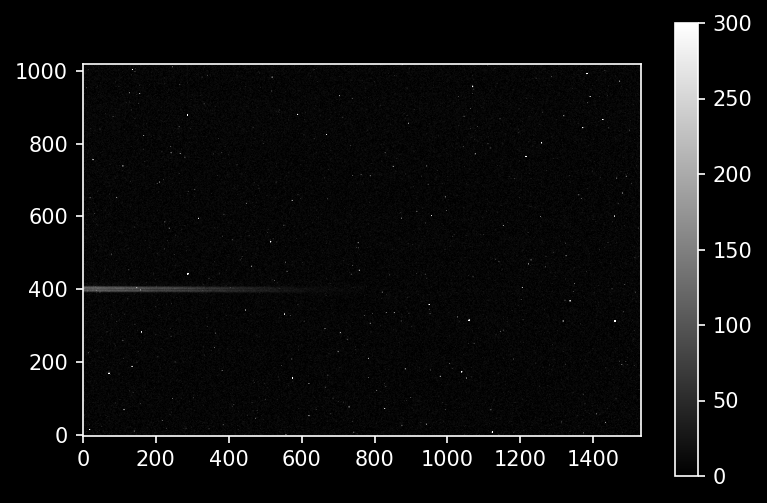

In [43]:
europa_30s_image_data =  (np.mean([fits.getdata(x) for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\europa_30s002.FIT")],
                      axis=0)
              - np.mean([fits.getdata(x)
                         for x in glob.glob("\\Users\\Sydnee O'Donnell\\OneDrive\\UF\\Obs Tech 2\\Labs\\Oct5th2022_CTO\\dark_30s00*.FIT")],
                        axis=0)
             )

eur_array = np.array(europa_30s_image_data)
eur_array = eur_array - np.median(europa_30s_image_data)

%matplotlib inline
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.dpi'] = 150
pl.matplotlib.style.use('dark_background') # Optional!
pl.imshow(europa_30s_image_data, cmap='gray', vmax=0, vmin=300)
pl.colorbar()

In [44]:
traces = {key: traces[key] for key in [2,3]}

(0.0, 800.0, 369.0, 439.0)

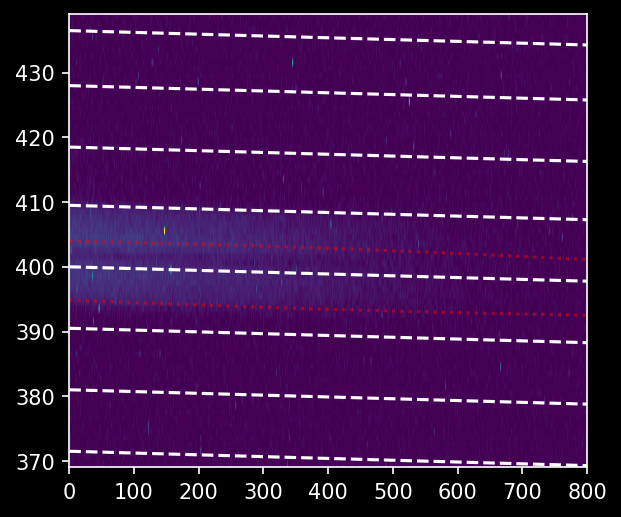

In [45]:
# We fit a 2rd-order polynomial
polymodel = Polynomial1D(degree=2)
linfitter = LinearLSQFitter()
fitted_polymodels = {index: linfitter(polymodel, xvals[:xend], weighted_yaxis_values[:xend])
                     for index, weighted_yaxis_values in traces.items()}

pl.imshow(eur_array[ystart:yend, :xend],
          extent=[0,xend,ystart,yend],
          vmin=0, vmax=700,
         )
pl.plot([0,xend], ystart + intertrace_cuts + np.array([0,xend])[:,None] * slope, color='w', linestyle='--')
pl.gca().set_aspect(10)
for tracefit in fitted_polymodels.values():
    pl.plot(xvals[:xend], tracefit(xvals[:xend]), 'r:', alpha=0.5)
pl.axis((0,xend,ystart,yend))

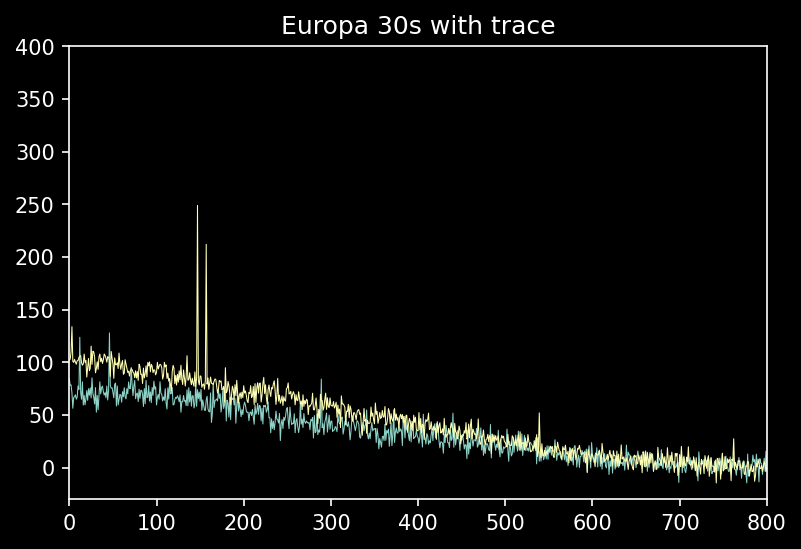

In [46]:
lmfitter = LevMarLSQFitter()
guess = Gaussian1D(amplitude=160, mean=0, stddev=5)

npixels_to_cut_trace = 4
spectra = {}
for trace_index, polymodel_trace in fitted_polymodels.items():
    trace_center = polymodel_trace(xvals)

    cutout_trace = np.array([eur_array[int(yval)-npixels_to_cut_trace:int(yval)+npixels_to_cut_trace, ii]
                        for yval, ii in zip(trace_center, xvals)]).T

    trace_profile = cutout_trace.mean(axis=1)
    trace_profile_xaxis = np.arange(len(trace_profile))
    fitted_trace_profile = lmfitter(model=guess, x=trace_profile_xaxis, y=trace_profile)
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    
    trace_avg_spectrum = np.array([np.average(
            eur_array[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
            weights=trace_profile)
                               for yval, ii in zip(trace_center, xvals)])
    spectra[trace_index] = trace_avg_spectrum
    
for index in spectra:
    pl.plot(spectra[index], linewidth=0.5)
    pl.title("Europa 30s with trace")
    pl.xlim(0,800)
    pl.ylim(-30,400)

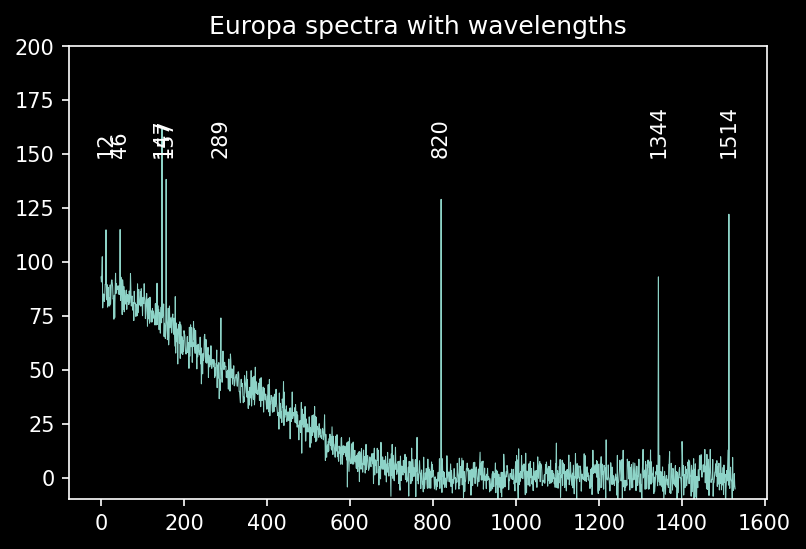

In [47]:
mean_eur = np.nanmean([spectra[ind] for ind in spectra], axis = 0)
pl.plot(mean_eur, linewidth = 0.5)
pl.title("Europa spectra with wavelengths")
pl.ylim(-10,200)

peaks,_ = scipy.signal.find_peaks(mean_eur, prominence = 30)

for peak in peaks:
    pl.text(peak,
           min([mean_eur[peak] + 100, 150]), peak,
           rotation = 90, horizontalalignment = 'center',)
    

In [48]:
peaks

array([  12,   46,  147,  157,  289,  820, 1344, 1514], dtype=int64)